In [1]:
import os
import glob
import pandas as pd

# 6score 的根目錄
root_dir = "/home/t113ab8043/Desktop/nanten_railway_code/資料集/已處理資料/6score"

# 轉換 中文類別 → 整數 label
label_map = {
    "正常": 0,
    "異常": 1,
    "故障": 2,
}

rows = []

# 走過每一個 turnout 資料夾：P1602N, P1602R, ...
for device_name in os.listdir(root_dir):
    device_path = os.path.join(root_dir, device_name)
    if not os.path.isdir(device_path):
        continue

    # 走過三個子資料夾：正常 / 異常 / 故障
    for class_name in ["正常", "異常", "故障"]:
        class_folder = os.path.join(device_path, class_name)
        if not os.path.isdir(class_folder):
            continue

        csv_paths = glob.glob(os.path.join(class_folder, "*.csv"))
        for path in csv_paths:
            rows.append({
                "file_path": path,
                "device": device_name,     # P1602N / P1602R / ...
                "class_name": class_name,  # 正常 / 異常 / 故障
                "label_idx": label_map[class_name],
            })

manifest = pd.DataFrame(rows)
print("總樣本數：", len(manifest))
display(manifest.head())

print("\n整體類別分布：")
print(manifest["class_name"].value_counts())


總樣本數： 4372


,file_path,device,class_name,label_idx
0,/home/t113ab8043/Desktop/nanten_railway_code/資...,P1602N,正常,0
1,/home/t113ab8043/Desktop/nanten_railway_code/資...,P1602N,正常,0
2,/home/t113ab8043/Desktop/nanten_railway_code/資...,P1602N,正常,0
3,/home/t113ab8043/Desktop/nanten_railway_code/資...,P1602N,正常,0
4,/home/t113ab8043/Desktop/nanten_railway_code/資...,P1602N,正常,0



整體類別分布：
class_name
正常    3222
異常    1028
故障     122
Name: count, dtype: int64


In [3]:
# =========================
# Sequence length analysis + export figure (for LaTeX)
# =========================
import numpy as np
import matplotlib.pyplot as plt

# 1) 計算每個 CSV 的序列長度（samples）
lengths = []
bad_files = []

for fp in manifest["file_path"].tolist():
    try:
        df = pd.read_csv(fp)
        seq_len = len(df)  # 每列=一個sample
        lengths.append(seq_len)
    except Exception as e:
        bad_files.append((fp, str(e)))

manifest["seq_len"] = lengths

print("\n✅ 已計算 seq_len")
print("seq_len 統計：")
print(manifest["seq_len"].describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.95]))

if bad_files:
    print("\n⚠️ 有檔案讀取失敗（前5筆）：")
    for fp, err in bad_files[:5]:
        print(" -", fp, "|", err)
    print("失敗總數：", len(bad_files))

# 2) 畫序列長度分布圖（Histogram）
seq = manifest["seq_len"].dropna().astype(int).values

# bin 數：用 sqrt rule（穩定又簡單）
bins = int(np.sqrt(len(seq)))
bins = max(20, min(bins, 80))  # 限制一下，不要太少或太多

plt.figure(figsize=(7, 4))
plt.hist(seq, bins=bins)
plt.xlabel("Sequence length (samples)")
plt.ylabel("Count")
plt.title("Distribution of actuation sequence lengths (100 Hz)")
plt.tight_layout()

# 3) 輸出成 PDF（給 LaTeX 用）
out_pdf = "sequence_length_distribution.pdf"
plt.savefig(out_pdf)  # 會存到你目前的 working directory
plt.close()

print(f"\n✅ 圖已輸出：{out_pdf}")
print("你接下來 LaTeX 就可以用：")
print(r"\includegraphics[width=\columnwidth]{sequence_length_distribution}")


KeyboardInterrupt: 

In [2]:
from sklearn.model_selection import train_test_split

# 先做 manifest（跟之前一樣）
# manifest 需要有 device 和 class_name 兩欄

# 新增一個「分層 key」：設備 + 類別
manifest["strata"] = manifest["device"] + "_" + manifest["class_name"]

print("不同 (device, class) 組合數：", manifest["strata"].nunique())
print(manifest["strata"].value_counts())

# 1) 先切出 train (75%) 和 temp (25%)
train_df, temp_df = train_test_split(
    manifest,
    test_size=0.25,
    stratify=manifest["strata"],   # ← 用 strata 分層
    random_state=42,
)

# 2) 再把 temp 切成 val/test
# 想要：val = 10%, test = 15%  → 在 temp(25%) 裡：val: 0.4, test: 0.6
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.6,
    stratify=temp_df["strata"],    # ← 一樣用 strata 分層
    random_state=42,
)

# # 1) 第一刀：切出 Test (0.2) 和 Train_Val (0.8)
# train_val_df, test_df = train_test_split(
#     manifest,
#     test_size=0.2,               # 總體的 20% 給 Test
#     stratify=manifest["strata"], # 根據 strata 分層
#     random_state=42,
# )

# # 2) 第二刀：從 Train_Val (0.8) 中切出 Val (總體的 0.1)
# # 計算比例：想要 0.1 / 目前手上的 0.8 = 0.125
# train_df, val_df = train_test_split(
#     train_val_df,
#     test_size=0.125,             # 0.125 * 0.8 = 0.1 (總體)
#     stratify=train_val_df["strata"],
#     random_state=42,
# )

print("Train size:", len(train_df))
print("Val size:  ", len(val_df))
print("Test size: ", len(test_df))
print("Total:     ", len(manifest))

print("\nTrain 類別分布：")
print(train_df["class_name"].value_counts())
print("\nVal 類別分布：")
print(val_df["class_name"].value_counts())
print("\nTest 類別分布：")
print(test_df["class_name"].value_counts())

print("\nTrain 設備分布：")
print(train_df["device"].value_counts())
print("\nVal 設備分布：")
print(val_df["device"].value_counts())
print("\nTest 設備分布：")
print(test_df["device"].value_counts())



# ==========================================
# Export shared split manifests (for fair baseline comparison)
# ==========================================
import os
SPLIT_OUTDIR = "/home/t113ab8043/Desktop/nanten_railway_code/split_protocolA"
os.makedirs(SPLIT_OUTDIR, exist_ok=True)

train_df[["file_path"]].to_csv(os.path.join(SPLIT_OUTDIR, "train.csv"), index=False)
val_df[["file_path"]].to_csv(os.path.join(SPLIT_OUTDIR, "val.csv"), index=False)
test_df[["file_path"]].to_csv(os.path.join(SPLIT_OUTDIR, "test.csv"), index=False)

print("✅ Saved shared split manifests to:", SPLIT_OUTDIR)
print("train/val/test sizes:", len(train_df), len(val_df), len(test_df))


不同 (device, class) 組合數： 16
strata
P1604R_正常    838
P1604N_正常    838
P1603N_正常    526
P1603R_正常    496
P1602N_正常    364
P1603R_異常    324
P1603N_異常    308
P1602R_異常    294
P1602R_正常    160
P1602N_異常    102
P1603N_故障     38
P1603R_故障     28
P1602R_故障     19
P1604N_故障     17
P1602N_故障     12
P1604R_故障      8
Name: count, dtype: int64
Train size: 3279
Val size:   437
Test size:  656
Total:      4372

Train 類別分布：
class_name
正常    2416
異常     772
故障      91
Name: count, dtype: int64

Val 類別分布：
class_name
正常    322
異常    102
故障     13
Name: count, dtype: int64

Test 類別分布：
class_name
正常    484
異常    154
故障     18
Name: count, dtype: int64

Train 設備分布：
device
P1603N    653
P1604N    641
P1603R    636
P1604R    635
P1602N    359
P1602R    355
Name: count, dtype: int64

Val 設備分布：
device
P1603N    88
P1604N    86
P1603R    85
P1604R    84
P1602N    47
P1602R    47
Name: count, dtype: int64

Test 設備分布：
device
P1603N    131
P1604N    128
P1604R    127
P1603R    127
P1602N     72
P1602R     71
Name: c

正在載入 Scaler 和 模型...
✅ Scaler 載入成功
✅ 模型參數載入成功
準備測試 656 筆資料...


/tmp/ipykernel_3491676/389298.py:71: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/home/t113ab8043/Desktop/nanten_railway_code/2_ML/loadin


Classification Report (LSTM Model):
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       484
           1       0.97      0.91      0.94       154
           2       0.94      0.94      0.94        18

    accuracy                           0.97       656
   macro avg       0.96      0.95      0.95       656
weighted avg       0.97      0.97      0.97       656

✅ Saved timing JSON: /home/t113ab8043/Desktop/nanten_railway_code/runs/lstm_loaded_protocolA_timing.json
[TIMING] inference: 11.289 ms/sample, 88.58 samples/s, total=7.406s


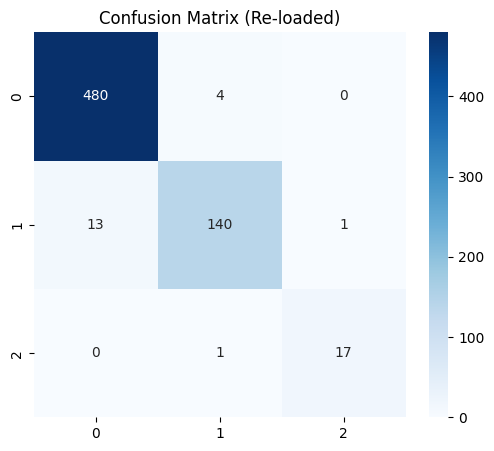

In [5]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import joblib  # 用來載入 Scaler
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import time
import json
import os

# ==========================================
# 1. 必須重新定義模型架構 (跟訓練時一模一樣)
# ==========================================
class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout):
        super(LSTMClassifier, self).__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0
        )
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x, lengths):
        packed_input = nn.utils.rnn.pack_padded_sequence(
            x, lengths.cpu(), batch_first=True, enforce_sorted=False
        )
        _, (h_n, _) = self.lstm(packed_input)
        last_hidden_state = h_n[-1]
        out = self.dropout(last_hidden_state)
        out = self.fc(out)
        return out

# ==========================================
# 2. 設定參數 (必須跟訓練時一致)
# ==========================================
CONT_COLS = ["NCurrent", "RCurrent", "WRVT"]
BIN_CAT_COLS = ["NLR", "SRWKR", "SNWKR", "RWKR", "NWKR", "RLR", "FOCR", "NWR", "RWR"]

INPUT_SIZE = len(CONT_COLS) + len(BIN_CAT_COLS) # 12
HIDDEN_SIZE = 128
NUM_LAYERS = 2
NUM_CLASSES = 3  # 正常0, 異常1, 故障2
DROPOUT = 0.3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ==========================================
# 3. 載入 Scaler 和 模型
# ==========================================
print("正在載入 Scaler 和 模型...")

# (A) 載入 Scaler
try:
    scaler = joblib.load('/home/t113ab8043/Desktop/nanten_railway_code/2_ML/loadingmodel/LSTM/test1/scaler.pkl')
    print("✅ Scaler 載入成功")
except FileNotFoundError:
    print("❌ 找不到 scaler.pkl，請確認路徑！")
    exit()

# (B) 初始化模型並載入權重
model = LSTMClassifier(INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, NUM_CLASSES, DROPOUT).to(device)

try:
    model.load_state_dict(torch.load('/home/t113ab8043/Desktop/nanten_railway_code/2_ML/loadingmodel/LSTM/test1/best_lstm_model_test.pth', map_location=device))
    model.eval()  # 切換到評估模式 (關閉 Dropout)
    print("✅ 模型參數載入成功")
except FileNotFoundError:
    print("❌ 找不到 best_lstm_model.pth，請確認路徑！")
    exit()

# ==========================================
# 4. 準備測試資料 (這裡需要 Dataset Class)
# ==========================================
# 為了方便，這裡必須把 EventDataset 和 collate_fn 再貼一次
# (在實際專案中，通常會把這些 Class 寫在一個單獨的 data_utils.py 裡然後 import)

class EventDataset(Dataset):
    def __init__(self, manifest_df, cont_cols, bin_cat_cols, scaler):
        self.manifest = manifest_df.reset_index(drop=True)
        self.cont_cols = cont_cols
        self.bin_cat_cols = bin_cat_cols
        self.scaler = scaler

    def __len__(self):
        return len(self.manifest)

    def __getitem__(self, idx):
        row = self.manifest.iloc[idx]
        path = row["file_path"]
        # 如果是純預測(沒有標籤)，這裡可以設個假標籤，或者改寫 Dataset
        label = int(row["label_idx"]) 

        df = pd.read_csv(path)
        for c in self.cont_cols + self.bin_cat_cols:
            if c not in df.columns: df[c] = 0.0

        # 使用載入的 scaler 進行轉換
        if self.scaler is not None and not df[self.cont_cols].empty:
            df[self.cont_cols] = self.scaler.transform(df[self.cont_cols])

        feats = []
        for c in self.cont_cols:
            vals = df[c].values.astype(np.float32)
            feats.append(torch.from_numpy(vals).unsqueeze(1))
        for c in self.bin_cat_cols:
            vals = df[c].fillna(0).astype(int).clip(0, 1).values.astype(np.float32)
            feats.append(torch.from_numpy(vals).unsqueeze(1))
            
        features_tensor = torch.cat(feats, dim=1)
        return {
            "features": features_tensor,
            "length": features_tensor.shape[0],
            "label": torch.tensor(label, dtype=torch.long),
        }

def collate_fn(batch):
    batch = [item for item in batch if item["length"] > 0]
    if not batch: return {}
    features_list = [item["features"] for item in batch]
    lengths_list = [item["length"] for item in batch]
    labels_list = [item["label"] for item in batch]
    padded_features = pad_sequence(features_list, batch_first=True, padding_value=0.0)
    return {
        "features": padded_features,
        "lengths": torch.tensor(lengths_list, dtype=torch.long),
        "labels": torch.stack(labels_list),
    }

# ==========================================
# 5. 載入你的測試資料清單 (Manifest)
# ==========================================
# 假設你已經有 test_df (如果沒有，你需要像原本程式碼前段一樣讀取檔案列表)
# 這裡為了演示，假設 test_df 已經存在 (如果是新 session，你需要重新生成 test_df)

if 'test_df' not in locals():
    print("⚠ 注意：你需要重新生成 test_df (檔案清單)，才能進行測試。")
    # 這裡你可以貼上原本程式碼最前面「產生 manifest 和切分」的那段邏輯
else:
    print(f"準備測試 {len(test_df)} 筆資料...")
    test_dataset = EventDataset(test_df, CONT_COLS, BIN_CAT_COLS, scaler)
    test_loader = DataLoader(test_dataset, batch_size=20, shuffle=False, collate_fn=collate_fn)


# ==========================================
# Timing: model-only inference on the test loader (no retraining)
# ==========================================
def _sync_if_cuda(device):
    if device.type == "cuda":
        torch.cuda.synchronize()

def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

@torch.no_grad()
def measure_inference(model, loader, device, warmup_batches=2):
    model.eval()
    # Warm-up
    for i, batch in enumerate(loader):
        if i >= warmup_batches:
            break
        features = batch['features'].to(device, non_blocking=True)
        lengths = batch['lengths']
        _ = model(features, lengths)

    _sync_if_cuda(device)
    t0 = time.perf_counter()
    n = 0
    for batch in loader:
        features = batch['features'].to(device, non_blocking=True)
        lengths = batch['lengths']
        bs = features.shape[0]
        _ = model(features, lengths)
        n += bs
    _sync_if_cuda(device)
    total_s = time.perf_counter() - t0

    ms_per_sample = (total_s / max(n, 1)) * 1000.0
    sps = n / max(total_s, 1e-12)
    return total_s, n, ms_per_sample, sps

# ==========================================
# 6. 開始預測
# ==========================================
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        features = batch['features'].to(device)
        lengths = batch['lengths']
        labels = batch['labels'].to(device)

        outputs = model(features, lengths)
        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# 顯示結果
print("\nClassification Report (LSTM Model):")
print(classification_report(all_labels, all_preds))

# ---- Write timing JSON (training time not available in this loading-only notebook) ----
infer_total_s, infer_n, ms_per_sample, sps = measure_inference(model, test_loader, device)

timing_record = {
    "model": "LSTM_packed_loaded",
    "protocol": "A_shared_split",
    "device": str(device),
    "torch_version": torch.__version__,
    "cuda_version": torch.version.cuda,
    "cudnn_version": torch.backends.cudnn.version() if torch.backends.cudnn.is_available() else None,
    "num_parameters": int(count_params(model)),
    "epochs_ran": None,
    "total_train_seconds": None,
    "avg_epoch_seconds": None,
    "batch_size": int(test_loader.batch_size) if getattr(test_loader, "batch_size", None) is not None else None,
    "total_infer_seconds": float(infer_total_s),
    "num_test_samples": int(infer_n),
    "ms_per_sample": float(ms_per_sample),
    "samples_per_second": float(sps),
    "note": "Timing measured from loaded model only; training time not recorded in this notebook."
}

OUT_JSON = "/home/t113ab8043/Desktop/nanten_railway_code/runs/lstm_loaded_protocolA_timing.json"
os.makedirs(os.path.dirname(OUT_JSON), exist_ok=True)
with open(OUT_JSON, "w", encoding="utf-8") as f:
    json.dump(timing_record, f, indent=2)

print(f"✅ Saved timing JSON: {OUT_JSON}")
print(f"[TIMING] inference: {ms_per_sample:.3f} ms/sample, {sps:.2f} samples/s, total={infer_total_s:.3f}s")

    
# 畫混淆矩陣
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix (Re-loaded)")
plt.show()

✅ 成功載入訓練紀錄 (history.pkl)


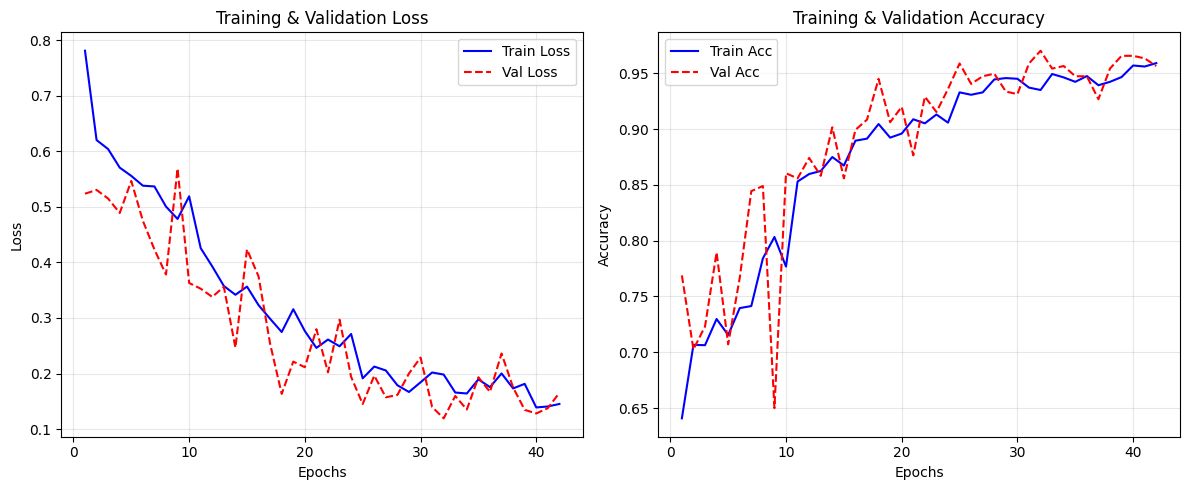

In [7]:
import matplotlib.pyplot as plt
import joblib

# 1. 載入訓練紀錄
try:
    history = joblib.load('/home/t113ab8043/Desktop/nanten_railway_code/2_ML/loadingmodel/test/history.pkl')
    print("✅ 成功載入訓練紀錄 (history.pkl)")
except FileNotFoundError:
    print("❌ 找不到 history.pkl，請確認是否有執行過訓練並存檔。")
    # 為了避免程式報錯，這裡做個假資料 (實際使用時會被 exit 擋下)
    history = None
    exit()

# 2. 開始畫圖
if history:
    epochs = range(1, len(history["train_loss"]) + 1)
    
    plt.figure(figsize=(12, 5))

    # ---- Loss Curve ----
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history["train_loss"], 'b-', label="Train Loss")
    plt.plot(epochs, history["val_loss"],   'r--', label="Val Loss")
    plt.title("Training & Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True, alpha=0.3)

    # ---- Accuracy Curve ----
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history["train_acc"], 'b-', label="Train Acc")
    plt.plot(epochs, history["val_acc"],   'r--', label="Val Acc")
    plt.title("Training & Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()